In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from keputils import koiutils as ku
from keputils import kicutils as kicu
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

starprops = pd.read_table('data/starprops_all.txt', delim_whitespace=True)
starprops['koistar'] = starprops['koi'].apply(ku.koistar)

sp = starprops.groupby('koistar').first()

huber_sp = kicu.DATA.ix[ku.DATA.ix[sp['koi'], 'kepid']]

fpp_all = pd.read_csv('fpp_final_table.csv', index_col=0)
fpp_all['koistar'] = fpp_all['koi.1'].apply(ku.koistar)
                        
len(starprops), len(sp), len(huber_sp)


(7135, 6102, 6102)

In [2]:
starprops.age.describe()

count    7135.000000
mean        9.538673
std         0.176010
min         9.000000
25%         9.456000
50%         9.594000
75%         9.653000
max        10.162000
Name: age, dtype: float64

In [3]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
from keputils import koiutils as ku
import re

starprops = pd.read_table('data/starprops_all.txt', delim_whitespace=True)
starprops['koistar'] = starprops['koi'].apply(ku.koistar)
starprops.index = starprops['koi']

sp = starprops
#sp = starprops.groupby('koistar').first()

def valpm(val, lo, hi, fmt='{}'):
    """Returns LaTeX for val +/- errs
    """
    p_err = '{{{}}}'.format(fmt).format(hi - val)
    m_err = '{{{}}}'.format(fmt).format(val - lo)
    val = '{{{}}}'.format(fmt).format(val)
    return '${{ {} }}^{{ +{} }}_{{ -{} }}$'.format(val, p_err, m_err)

def write_startable_tex(nrows=50, istart=1000, 
                        filename='document/table_stars.tex'):
    columns = ['mass', 'radius', 'Teff',
              'logg', 'feh', 'age', 'distance',
               'AV', 'Teff_prior', 'logg_prior', 'feh_prior']
    
    formats = {'mass':':.2f',
               'radius':':.2f',
               'Teff': ':.0f',
               'logg': ':.2f',
               'feh': ':.2f',
               'age': ':.2f',
               'distance': ':.0f',
               'AV' : ':.2f'}

    
    fout = open(filename,'w')
    fout.write("""
\\begin{deluxetable*}{lccccccccccc}
\\tablewidth{0pt}
\\tabletypesize{\\scriptsize}
\\tablecaption{Stellar Properties
\\tablabel{stars}}
\\tablehead{\\colhead{KOI} &
    \\colhead{$M_\\star$} &
    \\colhead{$R_\\star$} &
    \\colhead{$T_{\\rm eff}$} &
    \\colhead{$\\log g$} &
    \\colhead{[Fe/H]} &
    \\colhead{Age} &
    \\colhead{$d$} &
    \\colhead{$A_V$}&
    \\colhead{$\\pi\\left(T_{\\rm eff}\\right)$} &
    \\colhead{$\\pi\\left(\\log g\\right)$} &
    \\colhead{$\\pi\\left({\\rm [Fe/H]}\\right)$} \\\\
    \\colhead{} &
    \\colhead{($M_\odot$)} &
    \\colhead{($R_\odot$)} &
    \\colhead{(K)} &
    \\colhead{(cgs)} &
    \\colhead{(dex)} &
    \\colhead{(Gyr)} &
    \\colhead{(pc)} &
    \\colhead{(mag)} &
    \\colhead{} &
    \\colhead{} &
    \\colhead{} 
    }
\\startdata
"""
        )
    for i in range(istart, istart+nrows):
        k = sp.index[i]
        line = '{} &'.format(k)
        
        for c in columns:
            m = re.search('(\w+)_prior', c)
            if m:
                prop = m.group(1)
                mu,sig = sp.ix[k, ['{}_prior_mu'.format(prop),
                                  '{}_prior_sig'.format(prop)]]
                if np.isnan(mu):
                    val = '--'
                else:
                    val = '({{{0}}}, {{{0}}})'.format(formats[prop]).format(mu,sig)
            
            else:
                val, lo, hi = sp.ix[k, ['{}'.format(c),
                                       '{}_lo'.format(c),
                                       '{}_hi'.format(c)]]
                try:
                    if np.isnan(val):
                        val = '--'
                except:
                    pass
                
                if val != '--':
                    val = valpm(val, lo, hi, formats[c])
                

            line += '{}&'.format(val)                
                
        line = line[:-1]
        if i != istart+nrows-1:
            line += '\\\\ '
        line += '\n'
        fout.write(line)
    fout.write("""\\enddata
\\tablecomments{A portion of this table is shown for form and content.  
                The full table will be available online.}
\\end{deluxetable*}
"""            )
    fout.close()
    
if __name__=='__main__':
    write_startable_tex()
    write_startable_tex(len(sp), 0, 'document/table_stars_all.tex')

In [60]:
from keputils import koiutils as ku
from keputils import kicutils as kicu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
from matplotlib.collections import LineCollection

from keputils import koiutils as ku
from keputils import kicutils as kicu

starprops = pd.read_table('data/starprops_all.txt', delim_whitespace=True)
starprops['koistar'] = starprops['koi'].apply(ku.koistar)

sp = starprops.groupby('koistar').first()
sp['teff'] = sp['Teff']
sp['teff_lo'] = sp['Teff_lo']
sp['teff_hi'] = sp['Teff_hi']


huber_sp = kicu.DATA.ix[ku.DATA.ix[sp['koi'], 'kepid']]

vspace = {'Teff':500, 'radius':0.3, 'feh':0.2, 'mass':0.1}

def huber_compare(data=sp, prop='Teff', query='teff > 0', range=None, height=500, pix_width=2,
                 lw=0.5, ylim=None, huber_color='b', ax=None, labelpos=(0.03,0.93), 
                  alpha_lines=0.3, d3=False):

    data_kics = ku.DR24.ix[data['koi'], 'kepid']  
    huber_df = huber_sp.ix[data_kics].query(query)
    
    huber_values = np.sort(huber_df[prop.lower()])
    sorted_inds = np.argsort(huber_df[prop.lower()])
    
    huber_values_lo = np.array(huber_df[prop.lower()] + huber_df['{}_err2'.format(prop.lower())])[sorted_inds]
    huber_values_hi = np.array(huber_df[prop.lower()] + huber_df['{}_err1'.format(prop.lower())])[sorted_inds]
    
    kics = huber_df.index[sorted_inds]
    inds = np.arange(len(huber_values))

    if ax is None:
        fig, ax = plt.subplots(figsize=(9,3))
        #plt.figure(figsize=(14,5))
        #ax = plt.gca()
        
    ax.plot(inds, huber_values, color=huber_color, marker='_', ls='none')
    ax.fill_between(inds, huber_values_lo, huber_values_hi, 
                     facecolor=huber_color, alpha=0.1, color=huber_color)
    #plt.plot(inds, huber_values_lo, marker='_', ls='none', color='k', alpha=0.5)
    #plt.plot(inds, huber_values_hi, marker='_', ls='none', color='k', alpha=0.5)
    
    
    df = data.copy()
    df.index = ku.DR24.ix[df['koi'], 'kepid']
    
    n_inconsistent = 0
    
    segments = []
    labels = []
    colors = []
    alphas = []
    
    for i, kic in enumerate(kics):
        val_hi = df.ix[kic, '{}_hi'.format(prop)]
        val_lo = df.ix[kic, '{}_lo'.format(prop)]
        val = df.ix[kic, prop]
        
        val_huber = huber_df.ix[kic, prop.lower()]
        
        huber_lo = val_huber + huber_df.ix[kic, '{}_err2'.format(prop.lower())]
        huber_hi = val_huber + huber_df.ix[kic, '{}_err1'.format(prop.lower())]
        
        if val_lo < huber_hi and val_hi > huber_lo:
            color = 'k'
            alpha = alpha_lines
        else:
            color = 'r'
            alpha = 0.5
            ax.plot(i, val, marker='_', color='r', alpha=0.5, ms=3)
            n_inconsistent += 1

        colors.append(color)
        alphas.append(alpha)
        labels.append(df.ix[kic,'koi'])
        segments.append([(i,val_lo), (i,val_hi)])
        
        #ax.plot([i,i], [val_lo, val_hi], color=color, alpha=alpha, lw=lw)
    
    
    coll = LineCollection(segments, colors=colors, alpha=alpha)
    
    ax.add_collection(coll, autolim=True)
    ax.autoscale_view()

    fig = plt.gcf()
    tooltip = mpld3.plugins.PointLabelTooltip(coll, labels)
    mpld3.plugins.connect(fig, tooltip)
    
    ax.set_ylabel(prop)
    if ylim is None:
        ylim = (huber_values.min() - vspace[prop], huber_values.max() + vspace[prop])
    ax.set_ylim(ylim)
    ax.set_xticks([])
    N = len(kics)
    
    ax.annotate('{}/{} inconsistent ({:.1f}%)'.format(n_inconsistent, N, float(n_inconsistent)/N*100),
                xy=labelpos, xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle='round',fc='w',lw=2),
                ha='left', va='top', color='r')
    ax.set_xlim(xmax=inds[-1])
    ax.yaxis.grid(True)
    return fig


In [ ]:
# do this for relatively small queries or it is pretty slow...
%matplotlib inline
mpld3.enable_notebook()
huber_compare(query='teff < 4000 and teff_prov=="PHO2"', prop='Teff', lw=2);
huber_compare(query='teff < 4000 and teff_prov=="PHO2"', prop='mass', lw=2);
huber_compare(query='teff < 4000 and (teff_prov=="SPE5" or teff_prov=="SPE60")', prop='Teff', lw=2);

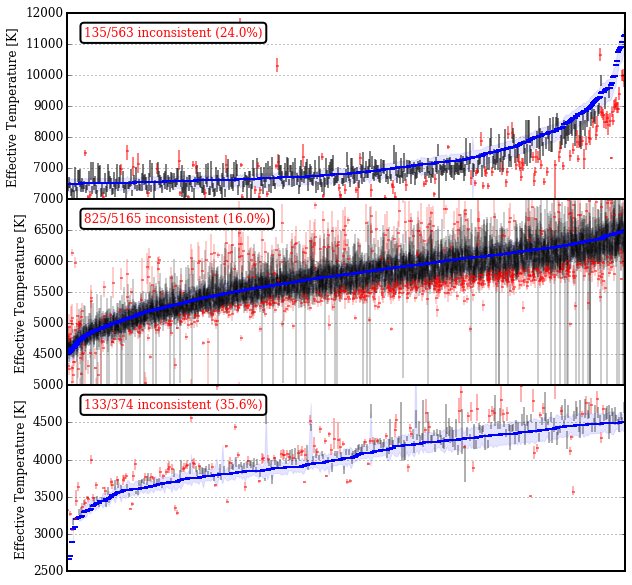

In [61]:
plt.close('all')
mpld3.disable_notebook()
def teff_compare_plots():
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10))
    huber_compare(query='teff > 6500', ax=ax1, lw=1, alpha_lines=0.3)
    ax1.set_yticks(ax1.get_yticks()[1:])
    ax1.set_ylabel('Effective Temperature [K]', fontsize=12)
    huber_compare(query='4500 < teff <= 6500', ax=ax2, alpha_lines=0.2)
    ax2.set_yticks(ax2.get_yticks()[1:])
    ax2.set_ylabel('Effective Temperature [K]', fontsize=12)
    huber_compare(query='teff <= 4500', ax=ax3, lw=1, alpha_lines=0.3)
    ax3.set_ylim(ymin=2500)
    ax3.set_ylabel('Effective Temperature [K]', fontsize=12)
    plt.subplots_adjust(hspace=0)
    plt.savefig('document/figures/hubercompare_teff.pdf')
    return fig

fig = teff_compare_plots();

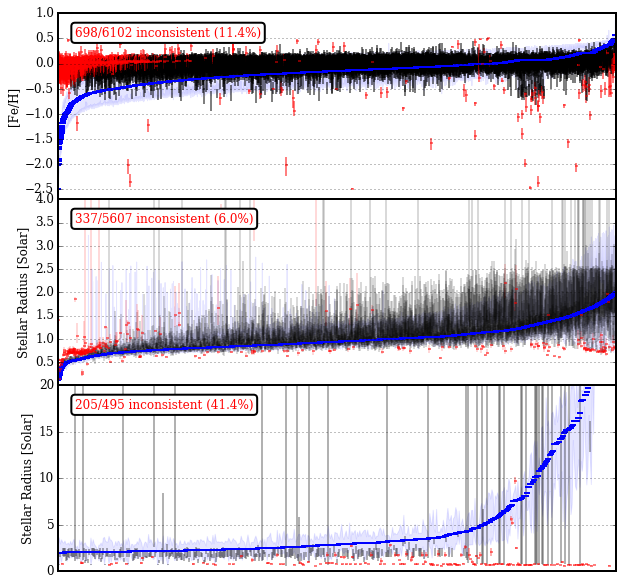

In [17]:
def feh_radius_compare():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))
    huber_compare(prop='feh', ax=ax1, alpha_lines=0.1)
    ax1.set_yticks(ax1.get_yticks()[1:])
    ax1.set_ylabel('[Fe/H]', fontsize=12)
    huber_compare(prop='radius', query='radius <= 2', ylim=(0,4), ax=ax2, alpha_lines=0.15);
    ax2.set_yticks(ax2.get_yticks()[1:])
    ax2.set_ylabel('Stellar Radius [Solar]', fontsize=12)
    huber_compare(prop='radius', query='2 < radius', ylim=(0,20), lw=1, ax=ax3)
    ax3.set_ylabel('Stellar Radius [Solar]', fontsize=12)
    plt.subplots_adjust(hspace=0)
    plt.savefig('document/figures/hubercompare_fehradius.pdf')
    
feh_radius_compare()

In [82]:
prob_score_thresh = 0.3
min_period = 0
fpp_thresh = 0.01 - 0.0006
lhood_thresh = -np.inf

fpp_col = 'FPP'

confirmed = fpp_all['disposition'] == 'CONFIRMED'
known_fp = fpp_all['disposition'] == 'FALSE POSITIVE'
candidate = fpp_all['disposition'] == 'CANDIDATE'
low_fpp = fpp_all[fpp_col] < fpp_thresh
hi_fpp = fpp_all[fpp_col] > 0.9
med_fpp = (fpp_all[fpp_col] >= fpp_thresh) & (fpp_all[fpp_col] <=0.9)
snr_low = fpp_all['MES'] < 10
snr_good = fpp_all['MES'] >= 10
on_target = (fpp_all['prob_ontarget'] >= 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
off_target = (fpp_all['prob_ontarget'] < 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
target_ambiguous = ((fpp_all['pos_prob_score'] < prob_score_thresh) | 
                    np.isnan(fpp_all['pos_prob_score']) | 
                    np.isnan(fpp_all['prob_ontarget']))
not_crazy = fpp_all['lhood_tot'] > lhood_thresh
crazy = fpp_all['lhood_tot'] <= lhood_thresh
short_period = fpp_all['period'] < min_period
period_ok = fpp_all['period'] >= min_period

fpp_calculated = np.isfinite(fpp_all[fpp_col]) 
d = fpp_all[fpp_calculated]

#reliable = (confirmed | candidate) & on_target & not_crazy
#print(sum(reliable))
#print(sum(reliable & low_fpp))
#print(sum(candidate & on_target & not_crazy & low_fpp))
#print(sum(confirmed))
#print(sum(candidate & high_fpp))
#print(sum(confirmed & high_fpp))

newfp = (candidate & fpp_calculated & not_crazy & on_target & hi_fpp & snr_good & period_ok)
newmed = (candidate & fpp_calculated & not_crazy & on_target & med_fpp & snr_good & period_ok)
newval = (candidate & fpp_calculated & not_crazy & on_target & low_fpp & snr_good & period_ok)

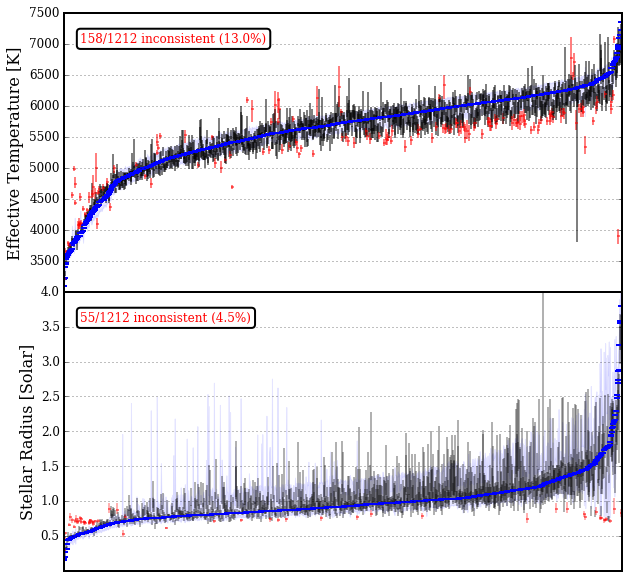

In [83]:
mpld3.disable_notebook()
val_sp = sp.ix[fpp_all[newval].koistar.unique()]

def validated_compare():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
    huber_compare(data=val_sp, prop='Teff', ax=ax1, alpha_lines=0.15, ylim=(3000,7500))
    ax1.set_yticks(ax1.get_yticks()[1:])
    ax1.set_ylabel('Effective Temperature [K]', fontsize=16)
    huber_compare(data=val_sp, prop='radius', ax=ax2, alpha_lines=0.3, ylim=(0,4));
    ax2.set_yticks(ax2.get_yticks()[1:])
    ax2.set_ylabel('Stellar Radius [Solar]', fontsize=16)
    plt.subplots_adjust(hspace=0)
    plt.savefig('document/figures/validated_compare.pdf')
    
validated_compare()

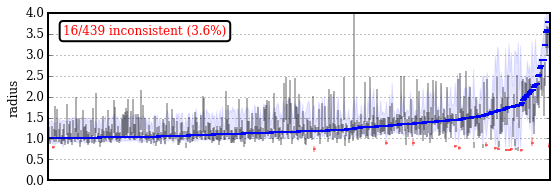

In [70]:
mpld3.enable_notebook()
huber_compare(data=val_sp, query='radius>1', prop='radius', lw=2, ylim=(0,4));

In [79]:
huber_sp.ix[ku.kepid('K04215')][['teff_prov','logg_prov','feh_prov']]

teff_prov    PHO1
logg_prov    KIC0
feh_prov     KIC0
Name: 9366617, dtype: object

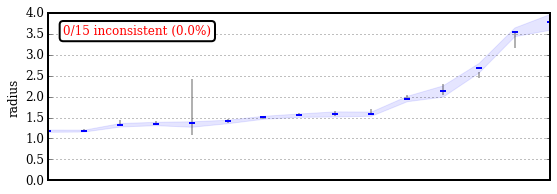

In [77]:
ast = list(huber_sp.logg_prov[huber_sp.logg_prov.str.match('AST')].unique())
huber_compare(data=val_sp, query='logg_prov in @ast', prop='radius', lw=2, ylim=(0,4));

array(['AST8', 'AST9', 'AST54', 'AST10', 'AST56', 'AST55', 'AST11'], dtype=object)

In [72]:
huber_sp.logg_prov.unique()

array(['AST8', 'TRA20', 'SPE3', 'SPE18', 'KIC0', 'TRA23', 'TRA22', 'TRA21',
       'SPE26', 'SPE59', 'PHO54', 'SPE58', 'SPE63', 'SPE32', 'SPE61',
       'SPE31', 'TRA64', 'SPE27', 'TRA42', 'TRA30', 'AST9', 'TRA25',
       'SPE57', 'SPE48', 'TRA40', 'TRA51', 'TRA66', 'TRA29', 'TRA50',
       'SPE5', 'SPE60', 'PHO43', 'SPE24', 'SPE38', 'TRA39', 'SPE12',
       'SPE62', 'SPE35', 'SPE34', 'SPE33', 'TRA44', 'PHO2', 'PHO41',
       'SPE4', 'SPE67', 'AST54', 'PHO16', 'PHO46', 'TRA65', 'TRA28',
       'SPE52', 'TRA37', 'SPE47', 'TRA36', 'AST10', 'AST56', 'SPE17',
       'AST55', 'AST11', 'SPE13', 'TRA45'], dtype=object)